## Topic Modeling and Clustering

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set()
BASE_PATH = Path("../DATASETS/1")

Topics normally overlap with each other; they are not clearly separated. The same is
true for documents: it is not possible to assign a document uniquely to a single topic;
a document always contains a mixture of different topics. The aim of topic modeling
is not primarily to assign a topic to an arbitrary document but to find the global
structure of the corpus.

This time we are more interested in the meaning and in the semantic content of the
speeches and how we can arrange them topically. We want to know what the speakers
are talking about and answer questions like these: 

Is there a structure in the docu‐ment corpus? 

What are the topics?

Which of them is most prominent? Does this change over time?

### Checking Statistics of the corpus

In [4]:
debates = pd.read_csv(BASE_PATH/"un-general-debates-blueprint.csv")

In [7]:
debates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [9]:
print(repr(debates.iloc[2666]["text"][0:200]))
print(repr(debates.iloc[4729]["text"][0:200]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General '
'\ufeffOn behalf of the State of Kuwait, it\ngives me pleasure to congratulate Mr. Han Seung-soo,\nand his friendly country, the Republic of Korea, on his\nelection as President of the fifty-sixth session of t'


In [11]:
import re
debates["paragraphs"] = debates["text"].map(lambda text: re.split('[.?!]\s*\n', text))
debates["number_of_paragraphs"] = debates["paragraphs"].map(len)

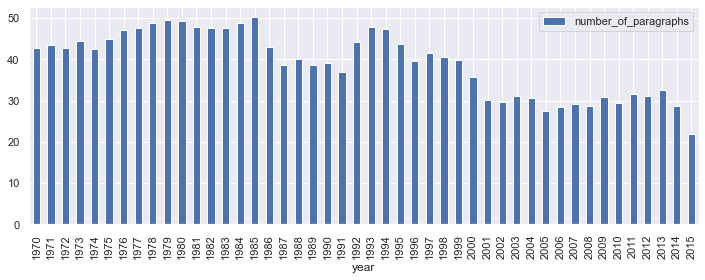

In [20]:
%matplotlib inline

debates.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize = (12, 4));

In [26]:
debates.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text', 'paragraphs', 'number_of_paragraphs'],
      dtype='object')

### Preparations

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from spacy.lang.en.stop_words import STOP_WORDS

In [41]:
tfidf_text = TfidfVectorizer(stop_words='english', min_df = 5, max_df=.7)
tfidf_vectors_text = tfidf_text.fit_transform(debates['text'])

In [38]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year }
                                for paragraphs, year in \
                                    zip(debates["paragraphs"], debates["year"])
                                for paragraph in paragraphs if paragraph])

In [39]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words='english', min_df = 5,
                                            max_df = .7)

tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df['text'])
tfidf_para_vectors.shapee

(282210, 25159)

### Nonnegative Matrix Factorization (NMF)

In [40]:
from sklearn.decomposition import NMF

In [42]:
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_vectors_text)
H_text_matrix = nmf_text_model.components_

C:\Users\HP\.virtualenvs\Text-Analysis-workouts-4nsmzFq6\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [43]:
W_text_matrix.shape, H_text_matrix.shape

((7507, 10), (10, 24604))

In [48]:
def display_topics(model, features, no_top_words = 5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print(f"\nTopic {topic}")
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],word_vector[largest[i]]*100.0/total))

In [52]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out(), 4)


Topic 0
 nuclear (1.13)
 weapons (0.59)
 disarmament (0.57)
 operation (0.45)

Topic 1
 terrorism (0.40)
 challenges (0.32)
 millennium (0.31)
 sustainable (0.30)

Topic 2
 africa (0.93)
 african (0.59)
 south (0.59)
 namibia (0.36)

Topic 3
 arab (1.00)
 israel (0.87)
 palestinian (0.59)
 lebanon (0.54)

Topic 4
 american (0.27)
 america (0.27)
 latin (0.27)
 panama (0.16)

Topic 5
 pacific (0.84)
 island (0.80)
 islands (0.74)
 small (0.71)

Topic 6
 republic (0.83)
 viet (0.72)
 nam (0.68)
 socialist (0.53)

Topic 7
 guinea (4.67)
 equatorial (1.86)
 papua (1.84)
 bissau (1.60)

Topic 8
 european (0.60)
 europe (0.44)
 cooperation (0.44)
 bosnia (0.36)

Topic 9
 cyprus (2.08)
 turkey (1.91)
 turkish (1.60)
 greece (1.18)


In [53]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([ 9.62136358, 15.70109721, 15.33099479, 10.23095155, 13.66408008,
        7.85638676,  7.51265984,  4.0675851 , 11.85528684,  4.15959426])